In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


1. Загрузил датасет со снимками с коптера. Использовал всего 45 снимков для быстроты работы, уж очень медленно обрабатываются и загружаюсят снимки. Загруженные Сегментированные изображения формата 4000*6000*3, то есть цветные, а не одномерные.
2.  Проведя анализ увидел, что изображение содержит 23 оттенка серого, с одинаковыми значениями цвета во всех трех слоях RGB. Создал OHE для Y с 23 классами.
3. Поместил 40 снимков на обучение в модель. val_dice_coef доходил до 0.6886. Визуально некоторые сегменты определялись прилично, а вот некоторые абсолютно не точно.
4. Возникли следующие вопросы: 
а. Как улучшать точность модели? кроме того, чтобы использовать больше снимков при обучении и кроме аугументации. Есть какие-то настройки сети, позволяющие улучшить ее качество? Как я понимаю, изменять кол-во нейронов и ядер на слоях не нужно, так как архитекрута U net вроде как и так оптимальная и меняя какие-то настрйоки внутри архитектуры, я ее не улучшу, а скорее наоборот. б. Всегда ли используется подход с OHE при сегментации изображений? 
в. Еще остался большой вопрос про использование претренированных сетей. Мы в примере брали pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet"). Потом в функции мы ее обучали каким-то загадачным способом, то используя Conv2d то Conv2dTranspose, при этом еще указывая какие-то конкретные слои из преобученной сети (18 слой, к примеру ). Вообщем вообще не разобрался, как использовать преобученные сети, не знаете, где можно почитать про это? 




In [ ]:
!ls

sample_data  small_segment.rar


А вот так загрузим картинки с Гугл Диска (делаем только один вариант загрузки)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [ ]:
!ls

images	labels	sample_data  small_segment.rar


Прочитаем списки наших файлов (проверить идентичность, если имена одинаковые или собрать порядок чтения любым доступным способом)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, fnmatch



In [ ]:
imag = os.listdir('/gdrive/My Drive/semantic_drone_dataset/original_images/')
imag_label = os.listdir('/gdrive/My Drive/semantic_drone_dataset/label_images_semantic/')


In [ ]:
imag.sort()

['000.jpg',
 '001.jpg',
 '002.jpg',
 '003.jpg',
 '004.jpg',
 '005.jpg',
 '006.jpg',
 '008.jpg',
 '011.jpg',
 '013.jpg',
 '014.jpg',
 '015.jpg',
 '016.jpg',
 '018.jpg',
 '019.jpg',
 '021.jpg',
 '022.jpg',
 '023.jpg',
 '026.jpg',
 '028.jpg',
 '031.jpg',
 '035.jpg',
 '038.jpg',
 '040.jpg',
 '041.jpg',
 '042.jpg',
 '043.jpg',
 '044.jpg',
 '045.jpg',
 '047.jpg',
 '049.jpg',
 '051.jpg',
 '052.jpg',
 '053.jpg',
 '055.jpg',
 '056.jpg',
 '057.jpg',
 '058.jpg',
 '059.jpg',
 '060.jpg',
 '062.jpg',
 '063.jpg',
 '065.jpg',
 '068.jpg',
 '070.jpg']

In [ ]:
imag_label.sort()

In [ ]:
imag_label

['000.png',
 '001.png',
 '002.png',
 '003.png',
 '004.png',
 '005.png',
 '006.png',
 '008.png',
 '011.png',
 '013.png',
 '014.png',
 '015.png',
 '016.png',
 '018.png',
 '019.png',
 '021.png',
 '022.png',
 '023.png',
 '026.png',
 '028.png',
 '031.png',
 '035.png',
 '038.png',
 '040.png',
 '041.png',
 '042.png',
 '043.png',
 '044.png',
 '045.png',
 '047.png',
 '049.png',
 '051.png',
 '052.png',
 '053.png',
 '055.png',
 '056.png',
 '057.png',
 '058.png',
 '059.png',
 '060.png',
 '062.png',
 '063.png',
 '065.png',
 '068.png',
 '070.png']

Задаю маршрут для чтения

In [ ]:
PAHT_label = '/gdrive/My Drive/semantic_drone_dataset/label_images_semantic/'
PAHT_image = '/gdrive/My Drive/semantic_drone_dataset/original_images/'
  

#Загружаем и уменьшаем картинки

можно обойтись исходным рахзмером или взять другой

ВАЖНО - размер по обеим сторонам должен делиться на 2 несколько раз (сколько будет сжатий кадра)

In [ ]:
images = []
segments = []
image_size = (400,600)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
  #segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))


In [ ]:
for i_name in imag_label:
  #images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))
 

In [ ]:
images

[<PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5C479C88>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5C4D7B70>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5C487160>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5A4F8198>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5A4EDA90>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5C487240>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5C487208>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5A4FA860>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5A4F62E8>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5F64A080>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5C47BBA8>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5C47F8D0>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5A4F0828>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5A4FEDD8>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x7F9B5A4FF860>,
 <PIL.Imag

Посмотрели на входные кадры

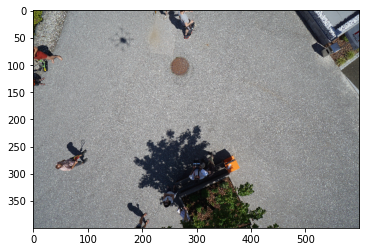

In [ ]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

Посмотрим на цели

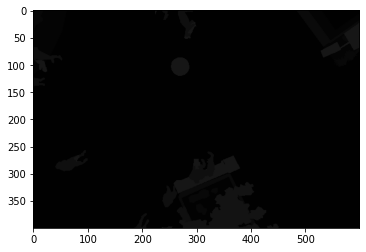

In [ ]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

#Создаём обучающую выборку

Собираем входные примеры:

In [ ]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [ ]:
yTrain_Test = []

for img in segments:
  y = image.img_to_array(img)
  yTrain_Test.append(y)

yTrain_Test = np.array(yTrain_Test)

In [ ]:
print(yTrain_Test.shape)

(45, 400, 600, 3)


In [ ]:
n=np.where((yTrain_Test[:,:,:,1]!=yTrain_Test[:,:,:,0]))

In [ ]:
n=np.unique(yTrain_Test[:,:,:,0])
n

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22.], dtype=float32)

In [ ]:
num_classes=[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22.]

In [ ]:
print(xTrain_Test.shape)

(45, 400, 600, 3)


In [ ]:
import cv2

Порстроим цвета , воспринимаемого диапазона для сегментированной картинки - это результат разметки, которую принесет разметчик

Делаем конвертер в one-hot_encoding для выходных примеров

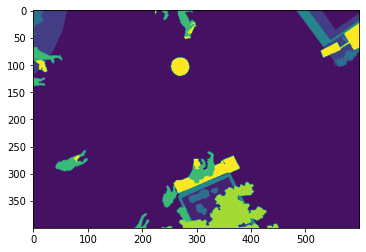

In [ ]:
def Color2index(y):
  arr_col=[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,13., 14., 15., 16., 17., 18., 19., 20., 21., 22.]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  


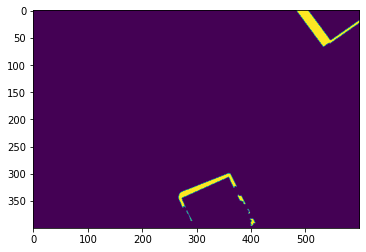

In [ ]:
plt.imshow(cat_yi[:,:,10])
plt.show()

Сегментированную картинку в  One hot encoding (разметка на 14 классов)**

In [ ]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [ ]:
print(yTrain_Test.shape)

(45, 400, 600, 23)


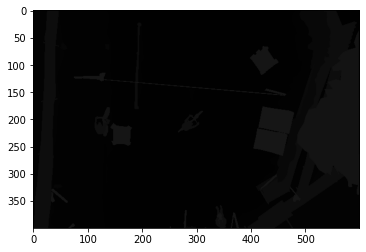

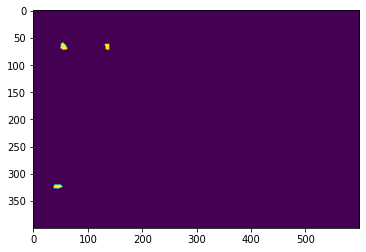

In [ ]:
n = 10
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,6]
plt.imshow(img.astype(float))
plt.show()

Делим на тест и трейн по числу N

In [ ]:
N = 40
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [ ]:
yTest.shape

(5, 400, 600, 23)

In [ ]:
print(xTrain.shape)
print(yTrain.shape)

(40, 400, 600, 3)
(40, 400, 600, 23)


#Создаём и обучаем U-net

In [ ]:
from tensorflow.keras.utils import plot_model

**Unet**

In [ ]:
def cuttedUnet(num_classes = 23, input_shape= (400, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 400, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 400, 600, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 400, 600, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 400, 600, 64) 0           batch_normalization_19[0][0]     
_______________________________________________________________________________________

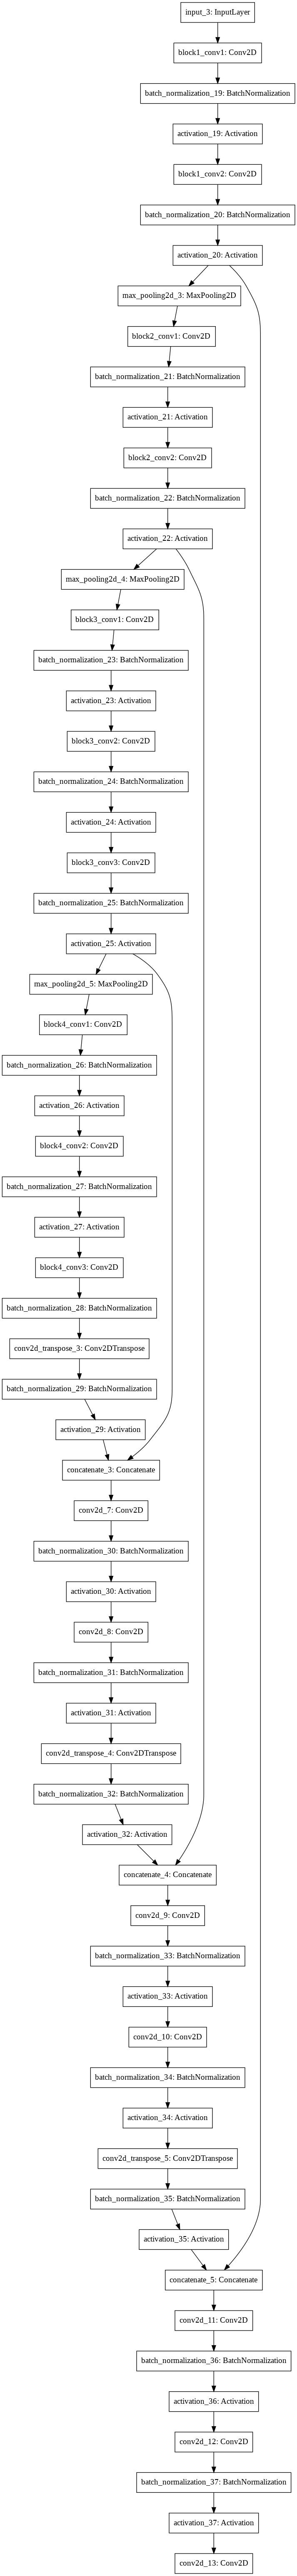

In [ ]:
modelC = cuttedUnet(23, (400, 600, 3))

plot_model(modelC, to_file='modelC.png')

In [ ]:

history = modelC.fit(xTrain, yTrain, epochs=50, batch_size=3, validation_data=(xTrain, yTrain))

Epoch 1/50
14/14 [==============================] - 34s 2s/step - loss: 2.1320 - dice_coef: 0.2806 - val_loss: 14.8081 - val_dice_coef: 0.0807
Epoch 2/50
14/14 [==============================] - 29s 2s/step - loss: 1.6310 - dice_coef: 0.4039 - val_loss: 14.8051 - val_dice_coef: 0.0805
Epoch 3/50
14/14 [==============================] - 29s 2s/step - loss: 1.4566 - dice_coef: 0.4284 - val_loss: 14.6973 - val_dice_coef: 0.0465
Epoch 4/50
14/14 [==============================] - 29s 2s/step - loss: 1.4041 - dice_coef: 0.4590 - val_loss: 14.7014 - val_dice_coef: 0.0373
Epoch 5/50
14/14 [==============================] - 29s 2s/step - loss: 1.3483 - dice_coef: 0.4526 - val_loss: 12.7638 - val_dice_coef: 0.0543
Epoch 6/50
14/14 [==============================] - 29s 2s/step - loss: 1.3576 - dice_coef: 0.4607 - val_loss: 9.9859 - val_dice_coef: 0.0946
Epoch 7/50
14/14 [==============================] - 29s 2s/step - loss: 1.3148 - dice_coef: 0.4729 - val_loss: 6.9096 - val_dice_coef: 0.0618
E

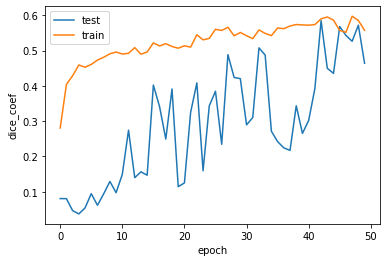

In [ ]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [ ]:
pred = modelC.predict(xTest)
print(pred.shape)

(5, 400, 600, 23)


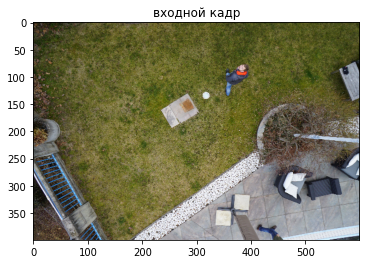

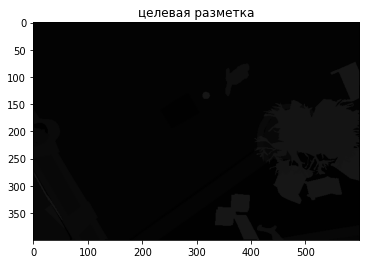

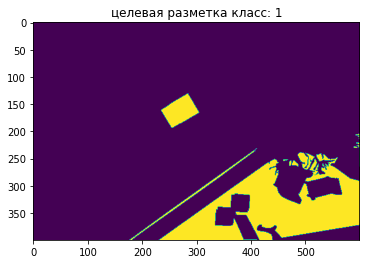

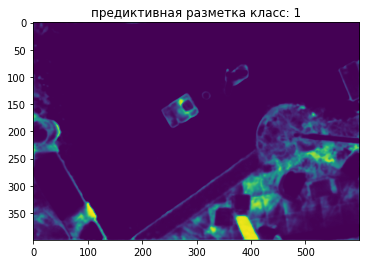

In [ ]:
n = 0
class_ =1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

**Претренированная  Unet**

In [ ]:
 pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 150, 128)      0     

In [ ]:
def unet_pre_train(num_classes = 23, input_shape= (400, 600, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Tensor("block3_pool/MaxPool_1:0", shape=(None, 50, 75, 256), dtype=float32)
Tensor("block2_pool/MaxPool_1:0", shape=(None, 100, 150, 128), dtype=float32)
Tensor("block1_pool/MaxPool_1:0", shape=(None, 200, 300, 64), dtype=float32)
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 400, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 400, 600, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 400, 600, 64) 36928       block1_conv1[0][0]               
______________________________________________________

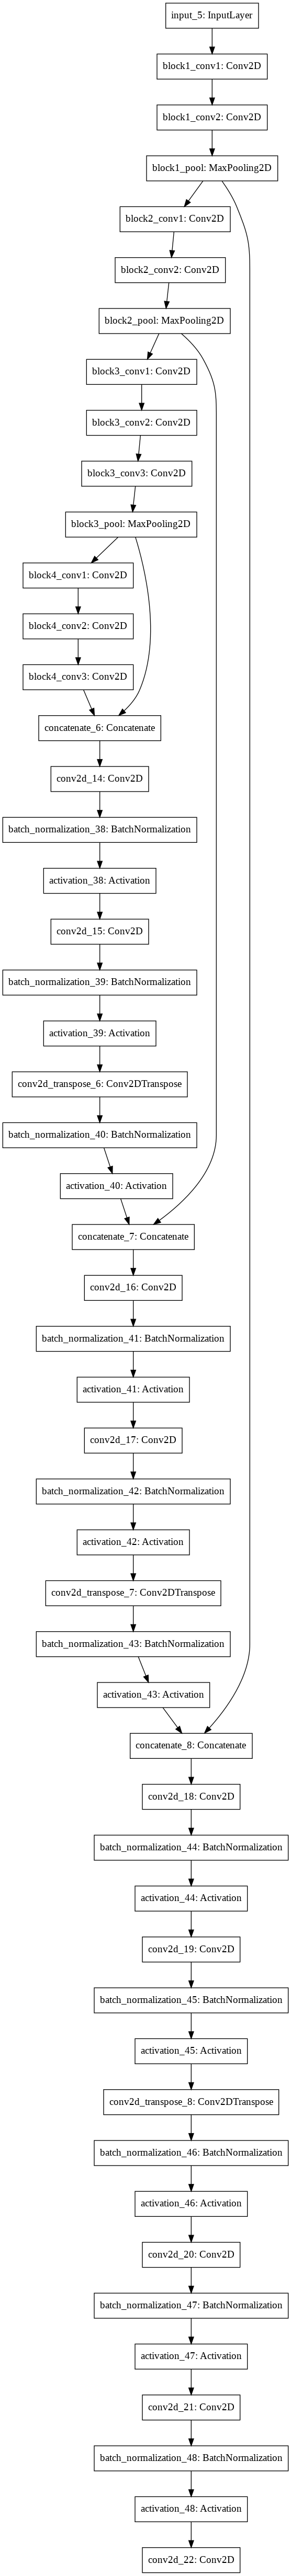

In [ ]:
modelU = unet_pre_train(num_classes = 23, input_shape= (400, 600, 3))

plot_model(modelU, to_file='modelU.png')

In [ ]:
history = modelU.fit(xTrain, yTrain, epochs=30, batch_size=3, validation_data=(xTrain, yTrain))

Epoch 1/30
14/14 [==============================] - 23s 2s/step - loss: 2.3247 - dice_coef: 0.2445 - val_loss: 6.9359 - val_dice_coef: 0.0488
Epoch 2/30
14/14 [==============================] - 21s 1s/step - loss: 1.5488 - dice_coef: 0.4400 - val_loss: 5.7889 - val_dice_coef: 0.1044
Epoch 3/30
14/14 [==============================] - 21s 1s/step - loss: 1.4132 - dice_coef: 0.4533 - val_loss: 4.5882 - val_dice_coef: 0.0584
Epoch 4/30
14/14 [==============================] - 21s 1s/step - loss: 1.3024 - dice_coef: 0.4783 - val_loss: 3.5646 - val_dice_coef: 0.0913
Epoch 5/30
14/14 [==============================] - 21s 1s/step - loss: 1.2888 - dice_coef: 0.4762 - val_loss: 3.3201 - val_dice_coef: 0.1440
Epoch 6/30
14/14 [==============================] - 21s 1s/step - loss: 1.2456 - dice_coef: 0.4893 - val_loss: 2.8016 - val_dice_coef: 0.1351
Epoch 7/30
14/14 [==============================] - 21s 1s/step - loss: 1.2124 - dice_coef: 0.5148 - val_loss: 2.7266 - val_dice_coef: 0.1771
Epoch 

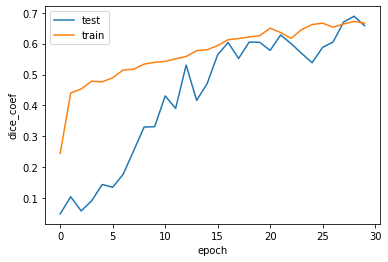

In [ ]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

#Распознаём обучающую выборку

In [ ]:
predu = modelU.predict(xTest)
print(pred.shape)


(5, 400, 600, 23)


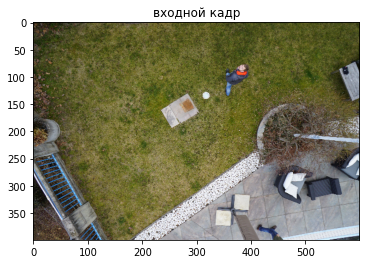

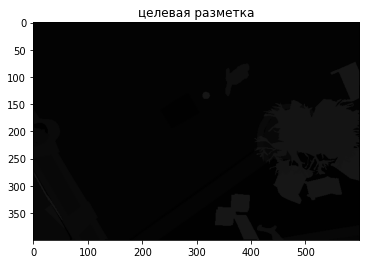

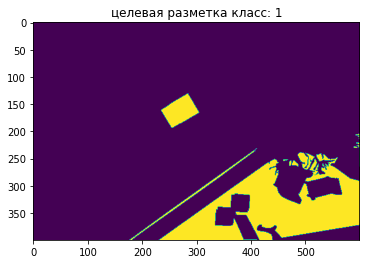

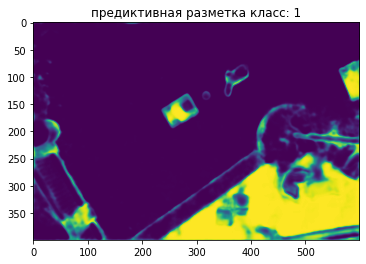

In [ ]:
n = 0
class_ = 1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()


Что еще делаем:

- аугментацию
- ищем новые примеры
- проверяем разметку
- меняем модель